In [6]:
import numpy as np
import pandas as pd
import itertools
import random
import datetime as dt
import pulp
# import gurobipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
df = pd.read_csv('test.csv')

In [3]:
df

,JOURNEY_ID,LISTING,ORDER_INDEX,VOLUME,WEIGHT,LAT,LNG,ACTION,CUSTOMER_TIMESLOT_START,CUSTOMER_TIMESLOT_END
0,194333,7985885,1,2994750,180,51.534870,-2.586000,pickup,2023-09-15T10:00:00Z,2023-09-15T16:00:00Z
1,194333,7985885,6,-2994750,-180,51.498838,-2.540213,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
2,194333,8040758,2,6101360,367,51.438089,-2.748221,pickup,2023-09-15T09:00:00Z,2023-09-15T14:00:00Z
3,194333,8040758,7,-6101360,-367,51.435782,-2.761534,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
4,194333,8043966,3,1526040,51,51.327580,-2.872980,pickup,2023-09-15T14:00:00Z,2023-09-15T15:00:00Z
5,194333,8043966,8,-1526040,-51,51.436162,-2.761252,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
6,194333,8049581,4,7350334,348,51.497130,-2.572550,pickup,2023-09-15T07:00:00Z,2023-09-15T08:00:00Z
7,194333,8049581,9,-7350334,-348,51.503330,-2.648020,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z
8,194333,8049945,5,1242000,90,51.469130,-2.606940,pickup,2023-09-15T07:00:00Z,2023-09-15T10:00:00Z
9,194333,8049945,10,-1242000,-90,51.368190,-2.912540,delivery,2023-09-14T23:00:00Z,2023-09-15T22:59:59Z


In [4]:
df.dtypes

JOURNEY_ID                   int64
LISTING                      int64
ORDER_INDEX                  int64
VOLUME                       int64
WEIGHT                       int64
LAT                        float64
LNG                        float64
ACTION                      object
CUSTOMER_TIMESLOT_START     object
CUSTOMER_TIMESLOT_END       object
dtype: object

In [7]:
df['CUSTOMER_TIMESLOT_START'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_START'])
df['CUSTOMER_TIMESLOT_END'] = pd.to_datetime(df['CUSTOMER_TIMESLOT_END'])

df['mins_start'] = df['CUSTOMER_TIMESLOT_START'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_START'].dt.minute
df['mins_end'] = df['CUSTOMER_TIMESLOT_END'].dt.hour * 60 + df['CUSTOMER_TIMESLOT_END'].dt.minute

In [8]:
# depends on the data date
today = pd.to_datetime('2023-09-15')

# if the start data is the previous date then repplace with 0
df.loc[df['CUSTOMER_TIMESLOT_START'].dt.date < today, 'mins_start'] = 0

/usr/local/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [9]:
df

,JOURNEY_ID,LISTING,ORDER_INDEX,VOLUME,WEIGHT,LAT,LNG,ACTION,CUSTOMER_TIMESLOT_START,CUSTOMER_TIMESLOT_END,mins_start,mins_end
0,194333,7985885,1,2994750,180,51.534870,-2.586000,pickup,2023-09-15 10:00:00+00:00,2023-09-15 16:00:00+00:00,600,960
1,194333,7985885,6,-2994750,-180,51.498838,-2.540213,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
2,194333,8040758,2,6101360,367,51.438089,-2.748221,pickup,2023-09-15 09:00:00+00:00,2023-09-15 14:00:00+00:00,540,840
3,194333,8040758,7,-6101360,-367,51.435782,-2.761534,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
4,194333,8043966,3,1526040,51,51.327580,-2.872980,pickup,2023-09-15 14:00:00+00:00,2023-09-15 15:00:00+00:00,840,900
5,194333,8043966,8,-1526040,-51,51.436162,-2.761252,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
6,194333,8049581,4,7350334,348,51.497130,-2.572550,pickup,2023-09-15 07:00:00+00:00,2023-09-15 08:00:00+00:00,420,480
7,194333,8049581,9,-7350334,-348,51.503330,-2.648020,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379
8,194333,8049945,5,1242000,90,51.469130,-2.606940,pickup,2023-09-15 07:00:00+00:00,2023-09-15 10:00:00+00:00,420,600
9,194333,8049945,10,-1242000,-90,51.368190,-2.912540,delivery,2023-09-14 23:00:00+00:00,2023-09-15 22:59:59+00:00,0,1379


# Parameters

## Assigned values

In [292]:
# location of depot
depot_lat = 51.327580
depot_lng = -2.606940

# average service time (mins)
svc = 30  

# speed 30 KM per hour
speed = 50

# Maximum capacity
q = 20000000
w = 2000

# Large constant
M = 10000

## Node sets

In [23]:
order_cnt = int(len(df)/2)

# all nodes including depot
n = [i for i in range(len(df)+2)]

# all pickup points
p_plus = [i for i in range(1, order_cnt+1)]

# all delivery points
p_minus = [i for i in range(order_cnt+1, order_cnt*2+1)]

# set of pickup and delivery points
p = [i for i in range(1, len(df)+1)]

# all departing points
n_plus = [i for i in range(len(df)+1)]

# all arrival points
n_minus = [i for i in range(1, len(df)+2)]

## Capacity

In [12]:
qi = df['VOLUME'].values
wi = df['WEIGHT'].values

## Travel distance / Travel time

In [13]:
dist = df[['LAT', 'LNG', 'ORDER_INDEX']]

# set depot
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':0}, ignore_index=True)
dist = dist.append({'LAT':depot_lat, 'LNG':depot_lng, 'ORDER_INDEX':11}, ignore_index=True)

dist = dist.sort_values('ORDER_INDEX')
dist = dist.reset_index(drop=True)

In [14]:
dist

,LAT,LNG,ORDER_INDEX
0,51.327580,-2.606940,0.0
1,51.534870,-2.586000,1.0
2,51.438089,-2.748221,2.0
3,51.327580,-2.872980,3.0
4,51.497130,-2.572550,4.0
5,51.469130,-2.606940,5.0
6,51.498838,-2.540213,6.0
7,51.435782,-2.761534,7.0
8,51.436162,-2.761252,8.0
9,51.503330,-2.648020,9.0


In [15]:
# can be changed to distance on google map
def haversine_distance(lat1, lon1, lat2, lon2):
    # unit: KM
    R = 6371.0

    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance


# travel time (mins)
def travel_time(distance):
    return (distance / speed) * 60  # not the real distance

In [16]:
dist_matrix = pd.DataFrame(index=[i for i in dist['ORDER_INDEX']], columns=[i for i in dist['ORDER_INDEX']])
for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            dist_matrix.loc[i, j] = haversine_distance(dist['LAT'][i], dist['LNG'][i], dist['LAT'][j], dist['LNG'][j])

In [17]:
dist_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,23.095264,15.720245,18.484989,19.003365,15.739642,19.59718,16.120305,16.138862,19.749064,21.699338,0.0
1.0,23.095264,NaN,15.55561,30.448089,4.298461,7.452263,5.107893,16.405122,16.36227,5.542069,29.248916,23.095264
2.0,15.720245,15.55561,NaN,15.031869,13.826664,10.380158,15.913184,0.95777,0.928322,10.039773,13.796135,15.720245
3.0,18.484989,30.448089,15.031869,NaN,28.099299,24.256458,29.920394,14.303073,14.349168,25.005807,5.285791,18.484989
4.0,19.003365,4.298461,13.826664,28.099299,NaN,3.919765,2.246491,14.761853,14.725007,5.269336,27.587311,19.003365
5.0,15.739642,7.452263,10.380158,24.256458,3.919765,NaN,5.679849,11.335846,11.303593,4.748959,23.980351,15.739642
6.0,19.59718,5.107893,15.913184,29.920394,2.246491,5.679849,NaN,16.858109,16.822765,7.478947,29.617681,19.59718
7.0,16.120305,16.405122,0.95777,14.303073,14.761853,11.335846,16.858109,NaN,0.046545,10.873695,12.892565,16.120305
8.0,16.138862,16.36227,0.928322,14.349168,14.725007,11.303593,16.822765,0.046545,NaN,10.830393,12.933054,16.138862
9.0,19.749064,5.542069,10.039773,25.005807,5.269336,4.748959,7.478947,10.873695,10.830393,NaN,23.706849,19.749064


In [18]:
time_matrix = dist_matrix.copy() 
for i in range(len(dist)):
    for j in range(len(dist)):
        if i != j:
            time_matrix.loc[i, j] = travel_time(dist_matrix[i][j])

In [19]:
time_matrix

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
0.0,NaN,27.714316,18.864294,22.181987,22.804038,18.88757,23.516616,19.344366,19.366634,23.698877,26.039205,0.0
1.0,27.714316,NaN,18.666732,36.537706,5.158153,8.942716,6.129471,19.686147,19.634724,6.650482,35.098699,27.714316
2.0,18.864294,18.666732,NaN,18.038243,16.591997,12.45619,19.09582,1.149324,1.113987,12.047728,16.555362,18.864294
3.0,22.181987,36.537706,18.038243,NaN,33.719158,29.107749,35.904473,17.163687,17.219002,30.006969,6.342949,22.181987
4.0,22.804038,5.158153,16.591997,33.719158,NaN,4.703718,2.69579,17.714224,17.670009,6.323203,33.104773,22.804038
5.0,18.88757,8.942716,12.45619,29.107749,4.703718,NaN,6.815818,13.603015,13.564311,5.69875,28.776421,18.88757
6.0,23.516616,6.129471,19.09582,35.904473,2.69579,6.815818,NaN,20.229731,20.187319,8.974736,35.541218,23.516616
7.0,19.344366,19.686147,1.149324,17.163687,17.714224,13.603015,20.229731,NaN,0.055854,13.048434,15.471078,19.344366
8.0,19.366634,19.634724,1.113987,17.219002,17.670009,13.564311,20.187319,0.055854,NaN,12.996472,15.519665,19.366634
9.0,23.698877,6.650482,12.047728,30.006969,6.323203,5.69875,8.974736,13.048434,12.996472,NaN,28.448219,23.698877


In [20]:
# pulp cannot accept NAN
dist_matrix.fillna(9999, inplace=True)
time_matrix.fillna(9999, inplace=True)

## Time window

In [26]:
tw = df[['mins_start', 'mins_end', 'ORDER_INDEX']]
tw.rename(columns={'mins_start':'a', 'mins_end':'b'}, inplace=True)

# set depot
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':0}, ignore_index=True)
tw = tw.append({'a':0, 'b':1379, 'ORDER_INDEX':11}, ignore_index=True)

tw = tw.sort_values('ORDER_INDEX')
tw = tw.reset_index(drop=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
tw

,a,b,ORDER_INDEX
0,0,1379,0
1,600,960,1
2,540,840,2
3,840,900,3
4,420,480,4
5,420,600,5
6,0,1379,6
7,0,1379,7
8,0,1379,8
9,0,1379,9


# Optimisation modelling

## Problem

In [294]:
prob = pulp.LpProblem("Min_Z", pulp.LpMinimize)

## Decision Variables

In [295]:
x = pulp.LpVariable.dicts('x', [(i, j) for i in n for j in n], cat='Binary')

ta = pulp.LpVariable.dicts("ta", range(len(n)), 0)    # time arriving to the point
ts = pulp.LpVariable.dicts("ts", range(len(n)), 0)    # time starting to service

z = pulp.LpVariable('z', lowBound=0)

late = pulp.LpVariable.dicts("late", range(len(n)), lowBound=0)
pl = pulp.LpVariable.dicts("pl", range(len(n)), lowBound=0)
cost = pulp.LpVariable.dicts("cost", range(len(n)), lowBound=0)
total_penalty = pulp.LpVariable('total_penalty', lowBound=0)

late_a = pulp.LpVariable.dicts("late_a", range(len(n)), 0, cat='Binary')   # whether arrival time later than early time window
late_b = pulp.LpVariable.dicts("late_b", range(len(n)), 0, cat='Binary')   # whether arrival time later than late time window

## Objective function

eq1

In [296]:
# eq1
prob += z, "Objective"

## Constraints

### Total Distance

eq2

In [297]:
# select the shortest path with the same z value
total_dist = pulp.lpSum([x[i, j] * dist_matrix[i][j] for i in n_plus for j in n_minus if i != j])

prob += total_dist, "TotalDistance"
prob += M * z + total_dist

### Cost

In [299]:
def penalty_late(time_diff):
    return 0.2 * time_diff

eq3

In [300]:
for i in n_plus:
    for j in n_minus:
        if i != j: 

            # max(0, ta-b)
            prob += tw['b'][j] - ta[j] <= M * (1- late_b[j])
            prob += tw['b'][j] - ta[j] >= (-M * late_b[j])

            prob += late[j] >= (ta[j] - tw['b'][j]) - M * (1 - x[i, j]) - M * (1 - late_b[j])
            prob += late[j] <= (ta[j] - tw['b'][j]) + M * (1 - x[i, j]) + M * (1 - late_b[j])
            prob += late[j] >= 0 - M * (1 - x[i, j]) - M * late_b[j]
            prob += late[j] <= 0 + M * (1 - x[i, j]) + M * late_b[j]

            # if x[i, j] == 0 then penalty = 0 
            prob += pl[j] <= M * x[i, j]

            # if x[i, j] == 1 then pl[j] = penalty_early(late[j])
            prob += pl[j] >= penalty_late(late[j]) - M * (1 - x[i, j])
            prob += pl[j] <= penalty_late(late[j]) + M * (1 - x[i, j])

prob += total_penalty == pulp.lpSum([pl[j] for i in n_plus for j in n_minus if i != j])

In [301]:
for i in p_plus:
    for j in n_plus:
        for k in n_minus:
            if i != j and (i+order_cnt) != k and j != k:

                # cost of pickup
                prob += cost[i] <= M * x[i, j]
                prob += cost[i] >= late[i] - M * (1 - x[i, j])

                # cost of delivery
                prob += cost[i+order_cnt] <= M * x[i+order_cnt, k]
                prob += cost[i+order_cnt] >= late[i+order_cnt] - M * (1 - x[i+order_cnt, k])

                # sum of pickup and delivery of each order and total penalty
                prob += z >= cost[i] + cost[i+order_cnt] + total_penalty

### Path

eq4, eq5, eq6, eq7, eq8, eq9

In [302]:
# eq4: each point has one route out except the end point
for i in n_plus:
    prob += pulp.lpSum([x[i, j] for j in n_minus if i != j]) == 1

# eq5: each point has one route in except the start point
for j in n_minus:
    prob += pulp.lpSum([x[i, j] for i in n_plus if i != j]) == 1

# eq6: starts from the depot to pickup point
prob += pulp.lpSum(x[0,j] for j in p_plus) == 1

# eq7: ends from delivery point to the depot
prob += pulp.lpSum(x[i, len(n_plus)] for i in p_minus) == 1

# eq8: no point can go to start point
prob += pulp.lpSum(x[i,0] for i in n_minus) == 0

# eq9: no point can go from end point
prob += pulp.lpSum(x[len(n_plus), i] for i in n_plus) == 0


### Precedence

eq10

In [303]:
# delivery later than pickup for each order pair
for i in p_plus:
    prob += ta[i] + svc + time_matrix[i][i+order_cnt] <= ta[i+order_cnt]

eq11, eq12, eq17

In [304]:
for i in n_plus:
    for j in n_minus:
        if i != j:
            
            # eq11, eq12
            if i == 0:
                prob += ts[i] + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j])
                prob += ts[i] + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j])
            else:
                prob += ts[i] + svc + time_matrix[i][j] - ta[j] <= M * (1 - x[i, j])
                prob += ts[i] + svc + time_matrix[i][j] - ta[j] >= -M * (1 - x[i, j])

            # eq17
            prob += tw['a'][j] - ta[j] <= M * (1- late_a[j])
            prob += tw['a'][j] - ta[j] >= (-M * late_a[j])

            prob += ts[j] >= ta[j] - M * (1 - x[i, j]) - M * (1 - late_a[j])
            prob += ts[j] <= ta[j] + M * (1 - x[i, j]) + M * (1 - late_a[j])
            prob += ts[j] >= tw['a'][j] - M * (1 - x[i, j]) - M * late_a[j]
            prob += ts[j] <= tw['a'][j] + M * (1 - x[i, j]) + M * late_a[j]


# Solution

In [305]:
pulp.LpSolverDefault.msg = 1
prob.solve()

1

In [306]:
print("Status:", pulp.LpStatus[prob.status])
print("Optimal value of z:", pulp.value(z))

Status: Optimal
Optimal value of z: 0.0


Solutions by sequence

In [307]:
route = []
for i in range(len(n)):
    for j in range(len(n)):
        if pulp.value(x[i, j]) == 1:
            route.append((i, j))

if route:
    sorted_route = [route[0]]
    for _ in range(len(route) - 1):
        for (i, j) in route:
            if sorted_route[-1][1] == i:
                sorted_route.append((i, j))
                break

print("Optimal route:", sorted_route)

Optimal route: [(0, 5), (5, 4), (4, 1), (1, 6), (6, 9), (9, 2), (2, 3), (3, 10), (10, 7), (7, 8), (8, 11)]


In [309]:
sorted_route

[(0, 5),
 (5, 4),
 (4, 1),
 (1, 6),
 (6, 9),
 (9, 2),
 (2, 3),
 (3, 10),
 (10, 7),
 (7, 8),
 (8, 11)]

In [310]:
for i in n:
    print(pulp.value(ta[i]), pulp.value(ts[i]))

None 0.0
489.86187 600.0
717.15194 717.15194
765.19018 840.0
454.70372 454.70372
18.88757 420.0
636.12947 636.12947
921.81403 921.81403
951.86988 951.86988
675.10421 675.10421
876.34295 876.34295
1001.2365 1001.2365


In [199]:
# route = []
# for i in range(len(n)):
#     for j in range(len(n)):
#         if pulp.value(x[i, j]) == 1:
#             route.append((i, j))

# if route:
#     sorted_route = []
#     arrival_time = pulp.value(t[route[0][1]])
#     penalty_e = pulp.value(pe[route[0][1]])
#     penalty_l = pulp.value(pl[route[0][1]])
#     time_cost = pulp.value(cost[route[0][1]])
#     sorted_route.append((route[0][0], route[0][1], arrival_time, penalty_e, penalty_l, time_cost))
#     for _ in range(len(route) - 1):
#         for (i, j) in route:
#             if sorted_route[-1][1] == i:
#                 value = time_matrix[i][j]
#                 arrival_time = pulp.value(t[j])
#                 penalty_e = pulp.value(pe[j])
#                 penalty_l = pulp.value(pl[j])
#                 time_cost = pulp.value(cost[j])
#                 sorted_route.append((i, j, arrival_time, penalty_e, penalty_l, time_cost))
#                 break

# print("Optimal route and values:")

# print(f'Start time is {pulp.value(t[0])}')

# for (i, j, arrival_time, penalty_e, penalty_l, time_cost) in sorted_route:
#     print(f"({i}, {j}): {arrival_time}, {penalty_e}, {penalty_l}, {time_cost}")

Optimal route and values:
Start time is 0.0
(0, 4): 480.0, 0.0, 0.0, 0.0
(4, 2): 540.0, 0.0, 0.0, 0.0
(2, 5): 582.45619, 0.0, 0.0, 0.0
(5, 9): 618.15494, 0.0, 0.0, 0.0
(9, 7): 661.20337, 0.0, 0.0, 0.0
(7, 1): 710.88952, 0.0, 0.0, 0.0
(1, 10): 775.98822, 0.0, 0.0, 0.0
(10, 3): 840.0, 0.0, 0.0, 0.0
(3, 8): 887.219, 0.0, 0.0, 0.0
(8, 6): 937.40632, 0.0, 0.0, 0.0
(6, 11): 990.92294, None, None, None


# Visualisation

### Result with total distance constraint

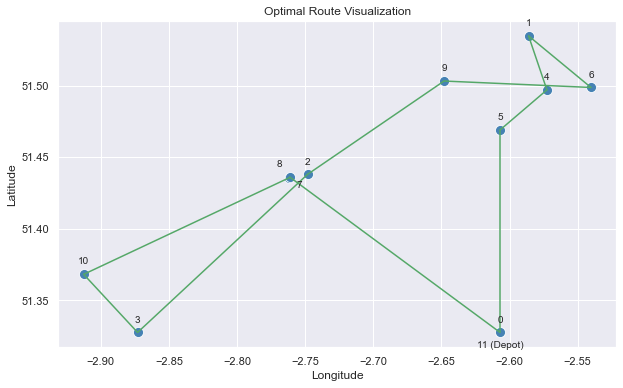

In [308]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')

# Annotating points
# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
    if i == 7:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
    elif i == 8:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
    elif i == 11:
        plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
    else:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')



# Plotting the route
for start, end in route:
    plt.plot([dist['LNG'][start], dist['LNG'][end]], [dist['LAT'][start], dist['LAT'][end]], 'g-')

plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

### Result without total distance constraint

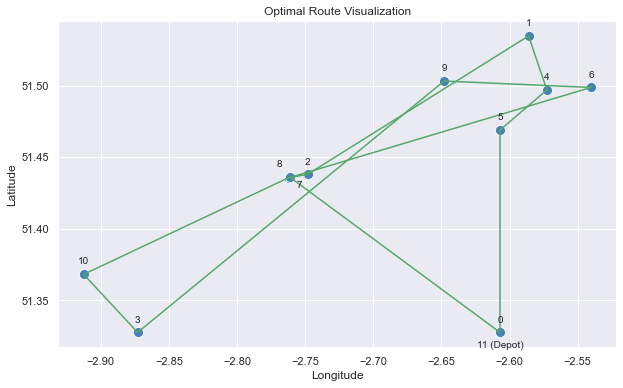

In [ ]:

# Plotting the points and the optimal route using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dist['LNG'], y=dist['LAT'], s=100, color='steelblue')

# Annotating points
# for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
#     plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')


for i, (lat, lng) in enumerate(zip(dist['LAT'], dist['LNG'])):
    if i == 7:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(10,-10), ha='center')
    elif i == 8:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(-10,10), ha='center')
    elif i == 11:
        plt.annotate(f'{i} (Depot)', (lng, lat), textcoords="offset points", xytext=(0,-15), ha='center')
    else:
        plt.annotate(i, (lng, lat), textcoords="offset points", xytext=(0,10), ha='center')



# Plotting the route
for start, end in route:
    plt.plot([dist['LNG'][start], dist['LNG'][end]], [dist['LAT'][start], dist['LAT'][end]], 'g-')

plt.title('Optimal Route Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()